# Dataset creation for sign spotting
Here, we preprocess the data from the Corpus NGT and split it up by its annotations. The data corresponding to an annotation are then sampled so they are of a fixed length. 

If the target fixed length is X frames, we can check if an annotation is already X frames long. If so, we can simply add its (preprocessed) data as a new entry in the train, validation or test set. If instead the length of the annotation is less than X frames, we add zero padding. 

If the annotation is longer than X frames, we undersample the frames. For instance, assuming we have a target length X=10 and an annotation with 22 frames, we first drop every other (every second) frame to get to 11 frames. We do not use random undersampling here to ensure at least some of the temporal structure of the annotation is maintained. Then, we drop 1 more frame randomly to get to our target of 10 frames.

We first create the dataset using the above method, before repeating the 'dataset creation' for the purposes of checking the correlation between the used features. The repeat is needed because for the correlation analysis, we do not want to  undersampling and zero padding be done, we simply use the annotations at their original length. After preparing for the correlation analysis, we use masking of the NaN values to not skew the correlation (e.g. by replacing NaNs with zeros). Lastly, we find out which features have correlation above some threshold so we can discard them before training our sign spotting model.

**Note:** this notebook should be run *twice*, once with `ling_features = True` and once with `ling_features = False`. See the code block after the imports for where to change this variable.

In [1]:
# Imports
import pympi
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
from tqdm import tqdm

import importlib

# Keep python tools up to date
from tools import tools, constants, make_dataset
importlib.reload(tools)
importlib.reload(constants)
importlib.reload(make_dataset)

# Import all functions from the tools
from tools.tools import load_dict
from tools.constants import PATHS, USE_MOUTHINGS # Path constants
from tools.make_dataset import*

np.random.seed(123) # Set random seed for consistency

In [2]:
# Whether to use the features of the mouth or not
mouthings = USE_MOUTHINGS
mouthings_str = '' if not mouthings else '_with_mouthings'
mouthing_ind = [13,14] # Mouthing indices (in Mediapipe's Face model)

# If we should normalize or not
normalize = True

In [3]:
# Root where all the annotated .eaf sign files are present
dataset_root = PATHS['cngt_vids_and_eaf']

# Path to a file of anns that only distinguishes between handedness
# We want to make sure two-handed signs are added once as an annotation and not twice
dataset_anns_path = PATHS['dataset_anns']

# List the .eaf files in the root directory to investigate
anns_in_dir = [file for file in os.listdir(dataset_root) if file.endswith('.eaf')]

# Loading the annotations for the dataset-tailored annotations
# Or we create them if they don't exist yet
if os.path.exists(dataset_anns_path):
    print('Loading annotations...')
    anns_with_tiers = load_dict(dataset_anns_path)
else:
    print('Making annotations without manual simultaneity...')
    anns_with_tiers = {}
    for i, ann_file in enumerate(anns_in_dir):
        print(i, end = '\r')
        # Read in the Eaf file 
        eaf_file = pympi.Elan.Eaf(os.path.join(dataset_root, ann_file))

        # Get the glosses and mouthings of the file
        anns_dict, _ = get_gloss_vals(eaf_file, True)
        # As explained above, we only distinguish handedness and not simultaneity
        anns_dict = man_sim_and_hand_dist(anns_dict, manual_sim = False)

        # Store the glosses, mouthings and tiers
        anns_with_tiers[ann_file] = anns_dict
    print('Storing...')
    with open(dataset_anns_path, 'wb') as f:
        pickle.dump(anns_with_tiers, f)
        
# Signbank dictionary info
df = pd.read_csv(PATHS['signbank_with_linguistics'])

# Dictionary which contains which videos (and signers) belong in test/train set
id_split = load_dict(PATHS['CNGT_split_ids'])

# Using only the top X signs if we have a list of them
top = -1 #1000
top_signs_path = PATHS['top_signs'].format(top)
if os.path.exists(top_signs_path):
    top_signs = np.load(top_signs_path)
else:
    top_signs = []
    
top_suffix = '_top' if len(top_signs) != 0 else ''

Loading annotations...


In [4]:
print('Signer split across train, validation and test sets')
# Printing which signers belong in the train, validation and test set
for key in id_split:
    print(key, sorted(set([x.split('_')[-1] for x in id_split[key]])))
# Note that the val and test sets are allowed to have the same signers (same Sxxx)
# But that they should contain different videos
val_vids = id_split['Val']
test_vids = id_split['Test']

Signer split across train, validation and test sets
Train ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S043', 'S044', 'S045', 'S049', 'S050', 'S059', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S069', 'S070', 'S075', 'S076', 'S077', 'S078', 'S083', 'S084', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092']
Val ['S011', 'S012', 'S019', 'S020', 'S027', 'S028', 'S039', 'S040', 'S041', 'S045', 'S046', 'S047', 'S048', 'S051', 'S052', 'S055', 'S056', 'S058', 'S071', 'S072', 'S073', 'S074', 'S079', 'S080', 'S081', 'S082', 'S085', 'S086']
Test ['S011', 'S012', 'S019', 'S020', 'S027', 'S028', 'S039', 'S040', 'S041', 'S042', 'S045', 'S046', 'S047', 'S048', 'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058', 'S071', 'S072', 'S073', 'S074', 'S080', 'S

# Data preprocessing and feature extraction
**Note:** `extract_features` can take a while to run with `linguistic_features = True` due to the preprocessing and extraction for each video being computationally heavy. With `linguistic_features = False` this should only take a few minutes.

*Expected runtime: 15-30min (with linguistic_features = True)*

# Creating the datasets

In [5]:
%%time
# Extract the linguistic features
ling_features, ling_mirrored = extract_features(anns_with_tiers, linguistic_features = True, mouthing_ind = mouthing_ind)

Number of CNGT files when split into numpy files: 4275
Feature-extracted data exists, loading...
Done!
CPU times: total: 2.61 s
Wall time: 54 s


100%|████████████████████████████████████████████████████████████████████████████████| 855/855 [01:36<00:00,  8.84it/s]


Example from X_train: [[ 0.46017638  0.40214708  0.9784996  ... -0.01298058  1.002342
   0.15156126]
 [ 0.29058886  0.19711134  0.8826425  ... -0.00848746  1.0038315
   0.13282895]
 [ 0.23168114  0.16862081  0.9759804  ...  0.00137353  1.0396366
   0.12343681]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


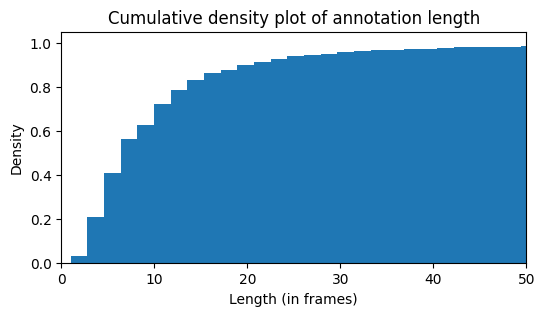

Mean annotation length 8.0

Number of empty anns: 0
Number of annotations: 110435
62.58% <= 10 frames, 5.16%>= than 10 frames, 32.26% = 10 frames
(10295,) (9585,)
Unique glosses: 2712
Mean shape: (120,) std shape: (120,)
	dataset 			data shape 		 label shape
Train                    	(180432, 10, 120)   		(180432,)
Train (no mirror)        	(90216, 10, 120)    		(90216,)
Validation               	(10295, 10, 120)    		(10295,)
Test                     	(9585, 10, 120)     		(9585,)
Stored all datasets.
CPU times: total: 1min 50s
Wall time: 2min 4s


In [6]:
%%time

# Remove the indices related to mouthings if we have mouthings = False
if not mouthings:
    for video in ling_features:
        # Remove from the landmark feature set (for 2 landmarks, we have to remove twice as many coordinates (x, y))
        ling_features[video] = ling_features[video][:, :-(2 * len(mouthing_ind))]
        ling_mirrored[video] = ling_mirrored[video][:, :-(2 * len(mouthing_ind))]

# Process the linguistic feature set
features_str = '_only_ling'
X, y, stats, var_len, ann_lengths, glosses = make_dataset(anns_with_tiers, ling_features, ling_mirrored,
                                                          df, val_vids, test_vids, top_signs, id_split, 
                                                          zero_pad=True)
X_train_var_len, y_train_var_len = var_len

# Print an example
print('Example from X_train:', np.array(X[0][0]))
# Display information about the annotation length
print_ann_length_stats(ann_lengths, stats)
# Encode the (string) labels (to convert them to int labels)
fitted, X, y = encode_labels(X, y, top_signs)
# Preprocess the data (normalize, remove NaNs, etc.)
X, y = prepare_data(X, y, fitted, normalize, features_str, mouthings_str)
# Save the data
save_dataset(X, y, features_str, mouthings_str, top_suffix)
del X, y

In [7]:
%%time
# Extract the landmark features 
lmrk_features, lmrk_mirrored = extract_features(anns_with_tiers, linguistic_features = False, mouthing_ind = mouthing_ind)

Number of CNGT files when split into numpy files: 4275
Feature-extracted data exists, loading...
Done!
CPU times: total: 1.67 s
Wall time: 29.3 s


In [8]:
%%time
# Remove the indices related to mouthings if we have mouthings = False
if not mouthings:
    for video in lmrk_features:
        # Remove from the landmark feature set (for 2 landmarks, we have to remove twice as many coordinates (x, y))
        lmrk_features[video] = lmrk_features[video][:, :-(2 * len(mouthing_ind))]
        lmrk_mirrored[video] = lmrk_mirrored[video][:, :-(2 * len(mouthing_ind))]

# Process the landmark feature set
features_str = '_only_lmrks'
X, y, stats, var_len, ann_lengths, glosses = make_dataset(anns_with_tiers, lmrk_features, lmrk_mirrored,
                                                          df, val_vids, test_vids, top_signs, id_split, 
                                                          zero_pad=True)
X_train_var_len, y_train_var_len = var_len

# Do the same steps as for the linguistic features
print('Example from X_train:', np.array(X[0][0]))
# print_ann_length_stats(ann_lengths, stats)
fitted, X, y = encode_labels(X, y, top_signs)
X, y = prepare_data(X, y, fitted, normalize, features_str, mouthings_str)
save_dataset(X, y, features_str, mouthings_str, top_suffix)
del X, y

100%|████████████████████████████████████████████████████████████████████████████████| 855/855 [01:38<00:00,  8.71it/s]


Example from X_train: [[ 0.15076137  0.34367633  0.17652202  0.26578987  0.15998888  0.1808011
   0.10913372  0.11031985 -0.0891459   0.26260012 -0.04855037  0.18104464
  -0.24313283  0.14812303 -0.36075974  0.1185661  -0.46700025  0.09448856
  -0.16265583  0.23631626 -0.3554976   0.16610467 -0.45491695  0.11758006
  -0.53315115  0.08361977 -0.24396682  0.26631808 -0.34596038  0.19743133
  -0.26894665  0.19074893 -0.19663072  0.20142204 -0.0322125   0.22253287
  -0.33732247  0.22467726 -0.2785883   0.22154921 -0.22249818  0.2332815
  -0.8515806   0.4952376  -0.71510553  0.4354874  -0.5632038   0.41410244
  -0.42610765  0.41354668 -0.75906706  0.45531225 -0.6619568   0.39986658
  -0.5032389   0.33993196 -0.41059017  0.36001456 -0.38010526  0.37977874
  -0.7428005   0.3661238  -0.5314028   0.38043892 -0.43020272  0.40595794
  -0.40155196  0.4259187  -0.7953844   0.40544558 -0.57252526  0.42472756
  -0.5265188   0.44477808 -0.551321    0.45487738 -0.62910557  0.41058815
  -0.63551474  0.4

(10295,) (9585,)
Unique glosses: 2712
Mean shape: (84,) std shape: (84,)
	dataset 			data shape 		 label shape
Train                    	(180432, 10, 84)    		(180432,)
Train (no mirror)        	(90216, 10, 84)     		(90216,)
Validation               	(10295, 10, 84)     		(10295,)
Test                     	(9585, 10, 84)      		(9585,)
Stored all datasets.
CPU times: total: 1min 41s
Wall time: 1min 59s


In [9]:
%%time
# The paths for the combined features
features_str = '_combined'
features_path = PATHS['features_data'].format(features_str)
mirrored_path = PATHS['mirrored_features_data'].format(features_str)

# Concatenate the data of the linguistic and landmark features
combined_features = {}
combined_mirrored = {}

for video in tqdm(ling_features):
    combined_features[video] = np.append(ling_features[video], lmrk_features[video], axis = 1)
    combined_mirrored[video] = np.append(ling_mirrored[video], lmrk_mirrored[video], axis = 1)
    
print('Example of video data shape with combined features:', combined_features[video].shape)

# Save the combined features set
features_data_np = np.array(list(combined_features.items()), dtype=object)
np.save(features_path, features_data_np)

# Same for the mirrored data
mirrored_data_np = np.array(list(combined_mirrored.items()), dtype=object)
np.save(mirrored_path, mirrored_data_np) 

100%|████████████████████████████████████████████████████████████████████████████████| 855/855 [08:50<00:00,  1.61it/s]


Example of video data shape with combined features: (3524, 204)
CPU times: total: 26.3 s
Wall time: 17min 17s


In [10]:
%%time
# Process the combined (linguistic + landmark) feature set
X, y, stats, var_len, ann_lengths, glosses = make_dataset(anns_with_tiers, combined_features, combined_mirrored,
                                                          df, val_vids, test_vids, top_signs, id_split, 
                                                          zero_pad=True)
X_train_var_len, y_train_var_len = var_len

# Do the same steps as for the linguistic features
print('Example from X_train:', np.array(X[0][0]))
# print_ann_length_stats(ann_lengths, stats)
fitted, X, y = encode_labels(X, y, top_signs)
X, y = prepare_data(X, y, fitted, normalize, features_str, mouthings_str)
save_dataset(X, y, features_str, mouthings_str, top_suffix)
# del X, y
del combined_features, combined_mirrored
del lmrk_features, lmrk_mirrored
del ling_features, ling_mirrored

100%|████████████████████████████████████████████████████████████████████████████████| 855/855 [02:16<00:00,  6.28it/s]


Example from X_train: [[ 0.46017638  0.40214708  0.9784996  ...  0.47420073 -0.61425924
   0.47811294]
 [ 0.29058886  0.19711134  0.8826425  ...  0.48002923 -0.65372825
   0.4794277 ]
 [ 0.23168114  0.16862081  0.9759804  ...  0.50512135 -0.69871604
   0.49667597]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(10295,) (9585,)
Unique glosses: 2712
Mean shape: (204,) std shape: (204,)
	dataset 			data shape 		 label shape
Train                    	(180432, 10, 204)   		(180432,)
Train (no mirror)        	(90216, 10, 204)    		(90216,)
Validation               	(10295, 10, 204)    		(10295,)
Test                     	(9585, 10, 204)     		(9585,)
Stored all datasets.
CPU times: total: 2min
Wall time: 5min


In [11]:
labels = load_dict(PATHS['label_encoder'].format(top_suffix))
labels['GEBOREN-A'], labels['AMSTERDAM'], labels['KLAAR-A'], labels['GEBAREN-A'], labels['NU-A']

(786, 178, 1171, 778, 1565)

In [12]:
def stats(X):
    shape = X.shape
    X_ = X.reshape(-1, shape[-1])
    mean, std = np.mean(X_, axis = 0), np.std(X_, axis = 0)
    print('Mean:', np.round(mean, 3))
    print('Std:', np.round(std, 3))
    return mean, std

In [14]:
X_train, X_train_no_mirr, X_val, X_test = X
print('X-train')
m, s = stats(X_train)
print('X-train (no mirroring)')
_, stats(X_train_no_mirr)
print('X-val')
_, stats(X_val)
print('X-test')
_, stats(X_test)

X-train


d:\program files (x86)\python39\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
d:\program files (x86)\python39\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Mean: [ 0.06   0.005 -0.017 -0.001 -0.034 -0.032 -0.046 -0.046 -0.039  0.02
  0.038 -0.017  0.001 -0.028 -0.009 -0.039 -0.01  -0.034 -0.006 -0.063
 -0.024 -0.005  0.051 -0.008  0.016 -0.003 -0.053  0.121  0.137 -0.005
 -0.023 -0.023 -0.023 -0.02  -0.043 -0.047 -0.046 -0.035  0.    -0.015
 -0.027 -0.021 -0.035 -0.041  0.007 -0.232 -0.013 -0.298 -0.008 -0.226
 -0.017 -0.216 -0.021 -0.21  -0.022 -0.221 -0.001  0.    -0.009 -0.054
 -0.005  0.017  0.001  0.035  0.034  0.047  0.048  0.039 -0.02  -0.034
  0.017 -0.004  0.029  0.007  0.04   0.009  0.033  0.004  0.082  0.027
  0.005 -0.046  0.008 -0.016  0.003  0.056 -0.105 -0.112  0.006  0.032
  0.029  0.029  0.025  0.071  0.07   0.066  0.049 -0.     0.025  0.046
  0.032  0.059  0.068  0.013  0.287 -0.011  0.329 -0.016  0.222 -0.013
  0.223 -0.012  0.228 -0.011  0.239  0.002 -0.001  0.007  0.     0.
  0.007 -0.232  0.005 -0.213  0.004 -0.226  0.003 -0.236  0.003 -0.259
  0.004 -0.264  0.002 -0.247  0.001 -0.251  0.001 -0.247  0.003 -0.235
  0.

((786, 178, 1171, 778, 1565),
 (array([-1.1969e-01, -1.3110e-01, -8.6975e-02, -1.0516e-01, -8.7463e-02,
         -9.4299e-02, -7.6172e-02, -1.0492e-01, -1.1279e-01, -1.4746e-01,
         -9.7900e-02, -9.3262e-02, -1.1798e-01, -9.5642e-02, -1.1432e-01,
         -8.6060e-02, -1.1249e-01, -1.2250e-01, -1.1237e-01,  1.3786e-02,
         -7.0000e-03,  3.1147e-03, -4.5074e-02, -9.0820e-02, -3.8788e-02,
         -6.2744e-02, -1.2939e-01,  1.6129e-02, -6.6345e-02, -5.1361e-02,
         -5.2246e-02, -6.2042e-02, -5.9784e-02, -5.8533e-02, -1.4137e-02,
         -2.9938e-02, -4.0344e-02, -4.9835e-02, -3.0838e-02, -1.5213e-02,
         -5.2452e-03,  1.3266e-03,  6.5384e-03,  5.6419e-03,  4.4670e-03,
          4.9133e-02,  9.1839e-04,  1.3062e-01,  1.4007e-04,  5.5267e-02,
          4.6501e-03,  5.4352e-02,  7.1030e-03,  5.3131e-02,  1.0323e-02,
          5.0110e-02, -3.2272e-03,  1.3428e-03,  9.3613e-03, -4.5868e-02,
          1.3382e-02, -4.6844e-02, -4.4342e-02, -4.9561e-02, -5.6381e-03,
        

In [15]:
for i in range(m.shape[0]):
    if abs(m[i]) > 0.1:
        print(i, m[i])

27 0.1212
28 0.1366
45 -0.2318
47 -0.298
49 -0.2262
51 -0.2161
53 -0.2101
55 -0.2213
86 -0.1051
87 -0.1119
104 0.2869
106 0.329
108 0.2223
110 0.2233
112 0.2278
114 0.2386
121 -0.2318
123 -0.2128
125 -0.2263
127 -0.2358
129 -0.2588
131 -0.2637
133 -0.247
135 -0.251
137 -0.2474
139 -0.235
141 -0.2417
143 -0.2408
145 -0.2393
147 -0.2312
149 -0.2345
151 -0.2324
153 -0.23
155 -0.257
157 -0.2272
159 -0.2264
161 -0.2257
163 0.2869
165 0.2922
167 0.3137
169 0.331
171 0.3267
173 0.3386
175 0.3464
177 0.345
179 0.3452
181 0.3284
183 0.337
185 0.3352
187 0.3325
189 0.3174
191 0.3286
193 0.321
195 0.32
197 0.3293
199 0.317
201 0.3162
203 0.3154


# Finding highly correlated features

In [ ]:
%%time
# Convert the variable length train data to numpy
X_train = np.array(X_train_var_len)
y_train = np.array(y_train_var_len)

# The above code gives us unevenly sized annotations, we can't just reshape
# So to add each frame as a row, we do it in a loop
x = []
for data_point in X_train:
    for frame in data_point:
        x.append(frame)
        
# We mask any NaN values so we can ignore them during later computations
x = np.array(x)
x = ma.masked_invalid(x)
x.shape

In [ ]:
%%time
# NOTE: this takes very long to compute (45-60 minutes on the tested hardware)
# This is why we try to avoid recomputing this if possible

# We compute the correlations between the values in the train data
corrs_path = PATHS['masked_corrs'].format(features_str)
cols = range(x.shape[-1]) # Number of columns = last dimension of x

# If we already computed the correlations, reuse them
if os.path.exists(corrs_path):
    print('Corrs being loaded...')
    corrs = np.load(corrs_path)
    # We need to convert to a masked array (can't save it like that)
    if 'masked' in corrs_path:
        corrs = ma.masked_invalid(corrs)
    corrs = list(corrs)
else: # Else, compute the correlations (this takes a while)
    print('Corrs being created...')    
    print('Data shape:', x.shape)

    corrs = []
    for col_1 in range(x.shape[-1]-1):
        for col_2 in range(col_1+1, x.shape[-1]):
            print(col_1, end = '\r')
            corr = ma.corrcoef(x[:,col_1], x[:, col_2])[0][1]
            corrs.append((corr, col_1, col_2))
    corrs_np = np.array(corrs)
    np.save(corrs_path, corrs_np)
print('Done.')

In [ ]:
# Continuation of the block above this one
print('Total correlations:\t\t{}'.format(len(corrs)))
num_high_corr = 0
high_corrs = []
removable = []
corr_thresh = 0.9
for corr in corrs:
    if abs(corr[0]) >= corr_thresh:
        corr = [corr[0], int(corr[1]), int(corr[2])]
        high_corrs.append(tuple(corr))
        # Remove the first feature of the high corr. pair
        removable.append(sorted(corr[1:])[-1])
        num_high_corr += 1
print('Num. of correlations >= {}:\t{}'.format(corr_thresh, num_high_corr))
to_remove = list(set(removable))

print('\nTo be removed:', to_remove)
remain = set(cols) - set(to_remove)

print('\nNumber of features we remove:', len(to_remove))
print('Number of features remaining:', len(list(remain)))

print('\n\nHigh correlation tuples:\n')
print(sorted(high_corrs, key = lambda x: x[0], reverse = True))

In [ ]:
# Analyze which features remain
def feature_selection_analysis(num_features, to_remove):
    half_features = round(num_features/2) - 1
    print(half_features)
    rem = set(range(x.shape[-1])) - set(to_remove)
    print('Remain length:', len(rem))
    rem_first = [r for r in sorted(rem) if r <= half_features]
    rem_second = [r-(half_features+1) for r in sorted(rem) if r > half_features]
    print('Remaining of left hand:')
    print(rem_first, '({} features)'.format(len(rem_first)))
    print('Remaining of right hand:')
    print(rem_second, '({} features)'.format(len(rem_second)))

    print('Extra features right hand:', sorted(set(rem_second) - set(rem_first)))
    print('Extra features left hand:', sorted(set(rem_first) - set(rem_second)))
    
    print('Same for both hands:', sorted(set(rem_second) & set(rem_first)))
# We use cols to get the number of features
feature_selection_analysis(len(cols), to_remove)

In [ ]:
# We round the values in the correlations, then remove masked values because we can't count them
# Then we print a counter of the (rounded) correlations
corrs_round = np.ma.array([np.round(c[0], 1) for c in corrs])
corrs_round_not_masked = corrs_round[~corrs_round.mask].flatten()
corrs_round_not_masked += 0. # This removes values that are rounded to -0.0, sets them to 0.0 (no minus)
print(Counter(corrs_round_not_masked))